# Controller Run and Analyze w/ Faceted Output


## Setup and Dependencies

In [1]:
# Set project root folder, to enable importing project files from subdirectories
from pathlib import Path
import os

path = Path().resolve()
root_path = str(path).split('notebooks')[0]
os.chdir(root_path)

# Import all shared dependencies and setup
from shared import *

In [2]:
import datetime
import time
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "png"
png_renderer = pio.renderers["png"]
png_renderer.width = 2000
png_renderer.height = 1200


from models.system_model_v3.model.params.init import params
from experiments.system_model_v3.run import run_experiment
from experiments.system_model_v3.configure import generate_params
from experiments.system_model_v3.post_process import post_process_results
from models.constants import RAY 

## Simulation Configuration

### Length of sims and number of runs

In [3]:
# Number of timesteps(hours) to run
# Max timesteps is 24 * 30 * 12 = 1 year
SIMULATION_TIMESTEPS = 24 * 30 * 6
#SIMULATION_TIMESTEPS = 24*10

# Number of runs. Each run uses a different simulated ETH dataset
MONTE_CARLO_RUNS = 1

### Parameters

In [4]:
# Set param values. These will override defaults
# Default param values can be found in `models/system_model_v3/model/params/init.py`
params_override = { 
    'debug': [False],
    'eth_trend': [1],# 0:no trend; >0:uptrend; <0:downtrend 
    'liquidity_demand_enabled': [False],
    'liquidity_demand_shock': [False],
    'liquidation_buffer': [2],
    'max_redemption_rate': [20], # used by SAFE owners
    'min_redemption_rate': [-20], # used by SAFE owners
    #'kp': [1e-8, 1e-7],
    #'ki': [5e-15, 5e-14],
    'kp': [5e-8],
    'ki': [5e-15],
    'alpha': [0.9999998716 * RAY],# 0.9999998716 -> 5% of integral is > 270 days old
    'rate_trader_count': [100],
    'rate_trader_mean_pct': [1.5],
    'rate_trader_min_pct': [1],
    'rate_trader_std_pct': [2 * (1.5-1)],
    'rate_trader_mean_days': [180],
    'rate_trader_min_days': [0],
    'rate_trader_std_days': [2 * (180-0)],
    'uniswap_fee': [0],
    'eth_leverager_target_min_liquidity_ratio': [2.7],
    'eth_leverager_target_max_liquidity_ratio': [2.7]
}
params_update = generate_params(params_override)
params.update(params_update)

## Run Simulation

In [5]:
start = time.time()
df_raw = run_experiment(timesteps=SIMULATION_TIMESTEPS,
               runs=MONTE_CARLO_RUNS, params=params);

In [6]:
df = post_process_results(df_raw, params, set_params=['eth_trend', 'kp', 'ki'])
print(f"Run experiment and post-process took {time.time() - start} secs")

Run experiment and post-process took 425.89368867874146 secs


In [7]:
# Optionally, trim results by timestep
#df_trim = df
df_trim = df[df['timestep'] >= 24*7][df['timestep'] <= 24*30*12]

In [8]:
df_trim['timestep'].head(3)

168    168
169    169
170    170
Name: timestep, dtype: int64

In [9]:
def facet_plot(df, run, facet_col, facet_row):
    """
    Show faceted plots for a singe simulation run
    """
    
    # Just plot first facet_col, facet_row since eth is same for all
    #first_col = df[f'{facet_col}'].unique()[0]
    #first_row = df[f'{facet_row}'].unique()[0]
    png_renderer.height = 700
    fig = px.line(
        df.query(f'run == {run}'),
          #.query(f'{facet_col} == {first_col}')
          #.query(f'{facet_row} == {first_row}'),
        title=f"ETH/USD",
        x="timestamp",
        y=["eth_price"],
        color_discrete_sequence=['blue'],
        labels={'timestamp': '', 'eth_price': ''},
        facet_col=f'{facet_col}',
        facet_row=f'{facet_row}'
    )
    fig.update_layout(width=500, height=2000)
    fig.data[0].name = "ETH/USD"
    fig.update_layout(title_x=0.5)
    fig.update_layout(showlegend=False)
    fig.update_layout({'legend_title_text': '', 'legend_x': 0.00, 'legend_y': 1.0})
    fig.update_layout(font={'size': 24})
    fig.update_traces(line=dict(width=2))
    fig.update_layout(yaxis={'title': ''}, xaxis={'title': ''})

    fig.show()

    fig = px.line(
        df.query(f'run == {run}'),
        title=f"RAI/USD",
        x="timestamp",       
        y=["curve_market_price", "market_price", "market_price_twap", "target_price"],
        color_discrete_sequence=['blue', 'purple', 'black', 'red'],
        labels={'timestamp': '', 'target_price': '', 'curve_market_price': '', 'market_price': '', 'market_price_twap': '', 'value': ''},
        facet_col=f'{facet_col}',
        facet_row=f'{facet_row}'
    )
    fig.data[0].name = "RAI/USD Curve"
    fig.data[1].name = "RAI/USD Feed"
    fig.data[2].name = "RAI/USD TWAP"
    fig.data[3].name = "Redemption Price"
    #fig.for_each_annotation(lambda a: a.update(text=a.text.replace("max_redemption_rate", "max rate")))

    fig.update_layout(title_x=0.5)
    fig.update_layout({'legend_title_text': '', 'legend_x': 0.0, 'legend_y': 0})
    fig.update_layout(showlegend=True)
    fig.update_layout(font={'size': 24})
    fig.update_traces(line=dict(width=2))
    fig.update_layout(yaxis={'title': ''}, xaxis={'title': ''})
    fig.show()
    
    fig = px.line(
        df.query(f'run == {run}'),
        title=f"Error Integral",
        x="timestamp",       
        y=["error_star_integral"],
        color_discrete_sequence=['blue'],
        labels={'timestamp': '', 'error_star_integral': '', 'value': ''},
        facet_col=f'{facet_col}',
        facet_row=f'{facet_row}'
    )
    fig.data[0].name = "Error Integral"


    fig.update_layout(title_x=0.5)
    fig.update_layout({'legend_title_text': '', 'legend_x': 0.0, 'legend_y': 0})
    fig.update_layout(showlegend=True)
    fig.update_layout(font={'size': 24})
    fig.update_traces(line=dict(width=2))
    fig.update_layout(yaxis={'title': ''}, xaxis={'title': ''})
    fig.show()
    
    
    fig = px.line(
        df.query(f'run == {run}'),
        title=f"Redemption Rate APY, Note: y-axis set to min/max rate in the run",
        x="timestamp",
        y=['apy'],
        color_discrete_sequence=["blue"],
        labels={'timestamp': '', 'apy': '', 'value': ''},
        facet_col=f'{facet_col}',
        facet_row=f'{facet_row}'
    )

    fig.data[0].name = "Redemption Rate APY"
    fig.for_each_annotation(lambda a: a.update(text=a.text.replace("max_redemption_rate", "max rate")))
     
    min_rate = df.query(f'run == {run}')['apy'].min()
    max_rate = df.query(f'run == {run}')['apy'].max()
    fig.update_yaxes(range=[min_rate, max_rate])
    fig.update_layout(title_x=0.5)
    fig.update_layout({'legend_title_text': '', 'legend_x': 0.00, 'legend_y': 1.0})
    fig.update_layout(showlegend=False)
    fig.update_layout(font={'size':24})
    fig.update_traces(line=dict(width=2))
    fig.update_layout(yaxis={'title': ''}, xaxis={'title': ''})
    fig.show()
    
    fig = px.line(
        df.query(f'run == {run}'),
        title=f"Rate trader balances(USD)",
        x="timestamp",       
        y=['rate_trader_total_base', 'rate_trader_base', 'rate_trader_total_rai_base'],
        color_discrete_sequence=['black', 'green', 'blue'],
        facet_col=f'{facet_col}',
        facet_row=f'{facet_row}'
    )

    fig.data[0].name = "Total"
    fig.data[1].name = "Base"
    fig.data[1].name = "RAI"
    fig.update_layout(title_x=0.5)
    fig.update_layout({'legend_title_text': '', 'legend_x': 0.00, 'legend_y': 1.0})
    fig.update_layout(showlegend=True)
    fig.update_layout(font={'size':24})
    fig.update_traces(line=dict(width=2))
    fig.show()

    fig = px.line(
        df.query(f'run == {run}'),
        title=f"ETH Leverager Collateral",
        x="timestamp",
        y=['eth_leverager_collateral'],
        color_discrete_sequence=['red'],
        facet_col=f'{facet_col}',
        facet_row=f'{facet_row}'
    )

    fig.update_layout(title_x=0.5)
    fig.update_layout({'legend_title_text': '', 'legend_x': 0.00, 'legend_y': 1.0})
    fig.update_layout(showlegend=False)
    fig.update_layout(font={'size':24})
    fig.update_traces(line=dict(width=2))
    fig.show()

    fig = px.line(
        df.query(f'run == {run}'),
        title=f"ETH Leverager C-ratio",
        x="timestamp",        
        y=['eth_leverager_cratio'],
        color_discrete_sequence=['black'],
        facet_col=f'{facet_col}',
        facet_row=f'{facet_row}'
    )

    fig.update_layout(title_x=0.5)
    fig.update_layout({'legend_title_text': '', 'legend_x': 0.00, 'legend_y': 1.0})
    fig.update_layout(showlegend=False)
    fig.update_layout(font={'size':24})
    fig.update_traces(line=dict(width=2))
    fig.show()

run=1


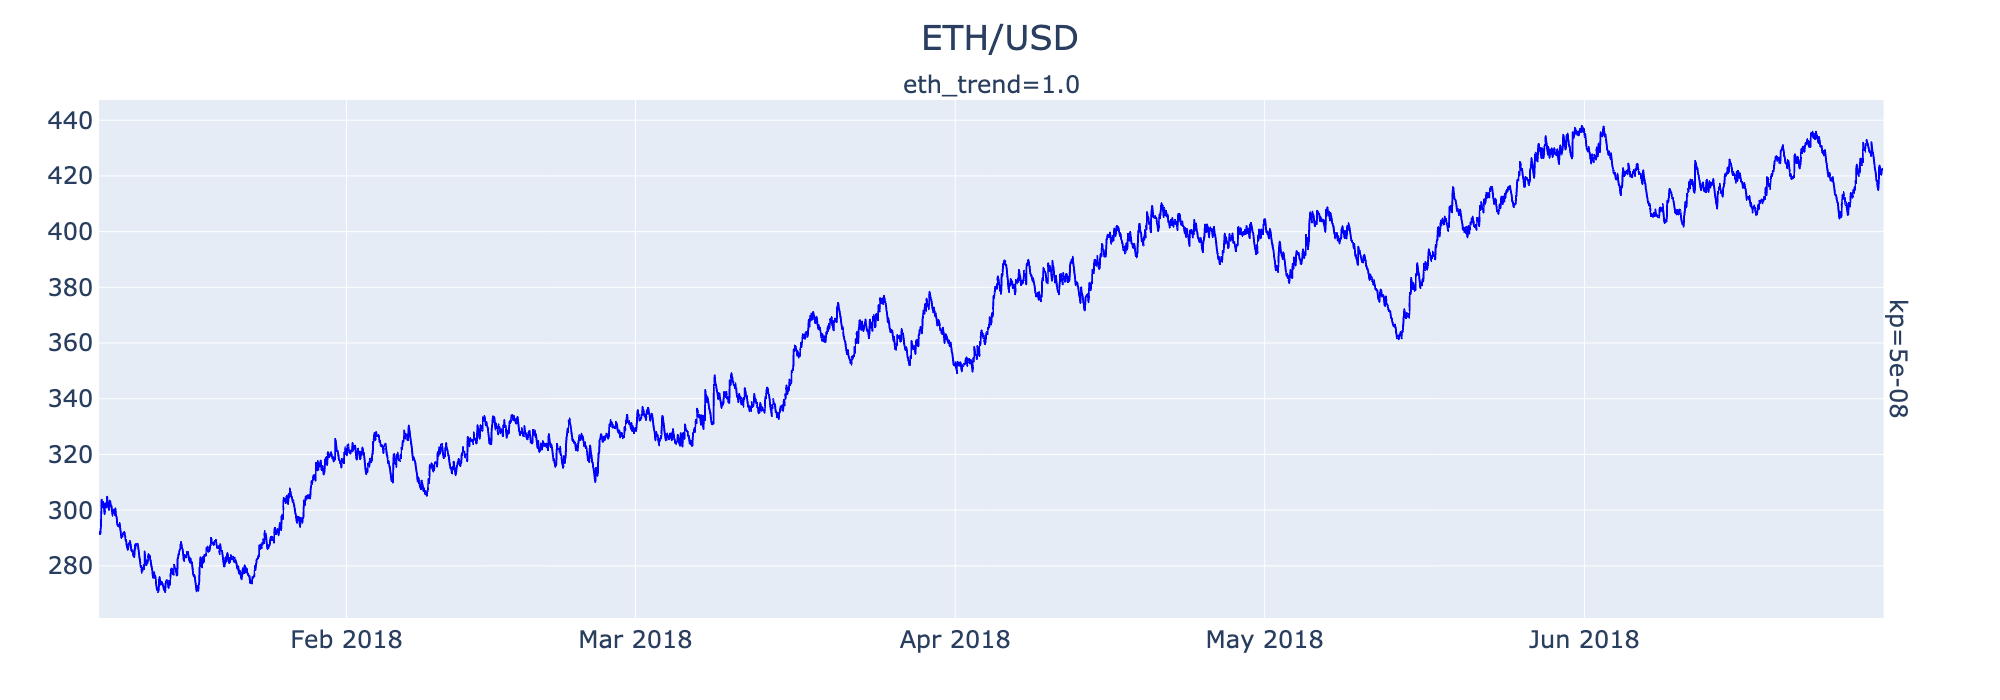

ValueError: All arguments should have the same length. The length of argument `y` is 4, whereas the length of  previously-processed arguments ['timestamp'] is 4153

In [10]:
for run in range(1, MONTE_CARLO_RUNS + 1):
    print(f"{run=}")
    facet_plot(df_trim, run, facet_col='eth_trend', facet_row='kp')

In [ ]:
df_trim[['market_price', 'market_price_twap']].head(50)

In [ ]:
len(df_trim)